In [ ]:
# подключаем библиотеки
# Работа с массивами данных
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation

from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Загрузка датасетов из облака google
import gdown

# Для работы с файлами в Colaboratory
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#скачиваем и разархивируем тексты

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/20writers.zip', None, quiet = True)

'20writers.zip'

In [ ]:
os.mkdir('/content/writers')

In [ ]:
! unzip 20writers.zip -d writers

Archive:  20writers.zip
  inflating: writers/Грибоедов.txt  
  inflating: writers/Достоевский.txt  
  inflating: writers/Каверин.txt  
  inflating: writers/Катаев.txt  
  inflating: writers/Куприн.txt  
  inflating: writers/Лермонтов.txt  
  inflating: writers/Лесков.txt  
  inflating: writers/Носов.txt  
  inflating: writers/Пастернак.txt  
  inflating: writers/Пушкин.txt  
  inflating: writers/Толстой.txt  
  inflating: writers/Тургенев.txt  
  inflating: writers/Чехов.txt  
  inflating: writers/Шолохов.txt  
  inflating: writers/Беляев.txt  
  inflating: writers/Булгаков.txt  
  inflating: writers/Васильев.txt  
  inflating: writers/Гоголь.txt  
  inflating: writers/Гончаров.txt  
  inflating: writers/Горький.txt  


In [ ]:
! ls writers

Беляев.txt    Гончаров.txt     Каверин.txt    Лесков.txt     Толстой.txt
Булгаков.txt  Горький.txt      Катаев.txt     Носов.txt      Тургенев.txt
Васильев.txt  Грибоедов.txt    Куприн.txt     Пастернак.txt  Чехов.txt
Гоголь.txt    Достоевский.txt  Лермонтов.txt  Пушкин.txt     Шолохов.txt


In [ ]:
# далее создадим список классов и одим список с элементами (текстами) и выделим обучающую и тестовую выборки
# функция я преобразования текста в строку и открытие текста
def one_line(file):
  with open(file, 'r') as f:
    text = f.read()
    return text.replace('\n', ' ')


class_list = []
all_x = []
path_to_writers ='/content/writers'
for class_name in os.listdir(path_to_writers):
  class_list.append(class_name)
  authors = path_to_writers + '/' + class_name
  all_x.append(one_line(authors))
print(class_list)
print(len(all_x))

[]
0


In [ ]:
# cltkftv 20% на обучающую выборку

train_x, test_x = [], []
for text in all_x:
  coef = int(round(len(text)*0.8))
  train_x.append(text[:coef])
  test_x.append(text[coef:])
print(len(train_x))
print(len(test_x))

0
0


In [ ]:
# перевести слова в токены
tokenizer = Tokenizer(num_words = 10000, filters = '!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower = True, oov_token = 'unknown')

# создаем словарь частотности
tokenizer.fit_on_texts(train_x)
tokenizer.fit_on_texts(test_x)


In [ ]:
# text_to_sequence и делим на выборки(окна), далее, чтоб сделать bag of words, sequence_to_matrix
#text_to_sequence возвращаем массив индексов
train_seq = tokenizer.texts_to_sequences(train_x)
test_seq = tokenizer.texts_to_sequences(test_x)

In [ ]:
# функция которая делит на подпоследовательности
def split_seq(sequance, win = 500, hop = 100):
  return [sequance[i : i + win] for i in range(0, len(sequance) - win + 1, hop)]

# функция которая возвращает векторы из этих последовательностей
def vec(seq_list, win = 500, hop = 100):
  count_list = len(seq_list)
  x, y = [], []
  for cls in range(count_list):

    vectors = split_seq(seq_list[cls])
    x += vectors
    y += [utils.to_categorical(cls, count_list)]*len(vectors)

  return np.array(x), np.array(y)


In [ ]:
train_x, train_y = vec(train_seq)
test_x, test_y = vec(test_seq)

# bag of words
train_bow_x = tokenizer.sequences_to_matrix(train_x.tolist())
test_bow_x = tokenizer.sequences_to_matrix(test_x.tolist())

In [ ]:
# Функция компиляции и обучения модели нейронной сети
# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='rmsprop',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Вывод схемы модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels= class_list,
                             title='',
                             optimizer='rmsprop',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 50)           500000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 500, 50)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_4 (Batc  (None, 500, 50)          200       
 hNormalization)                                                 
                                                                 
 bidirectional (Bidirectiona  (None, 500, 16)          3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 16)          1600      
 nal)                                                 

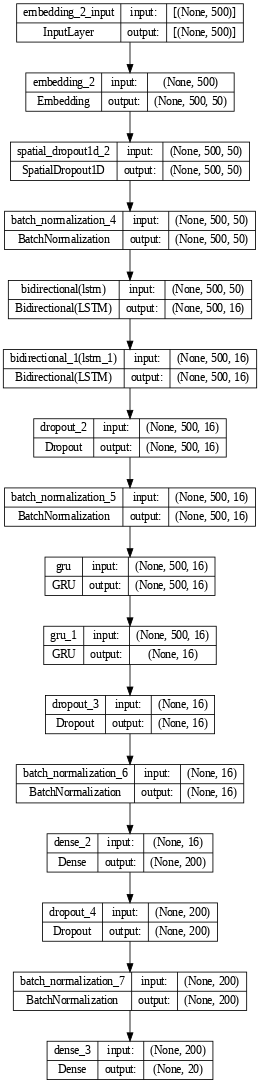

Epoch 1/100
136/136 [==============================] - 40s 203ms/step - loss: 3.1846 - accuracy: 0.0812 - val_loss: 2.9033 - val_accuracy: 0.1238
Epoch 2/100
136/136 [==============================] - 19s 140ms/step - loss: 2.8639 - accuracy: 0.1311 - val_loss: 2.6206 - val_accuracy: 0.1805
Epoch 3/100
136/136 [==============================] - 17s 128ms/step - loss: 2.6000 - accuracy: 0.1732 - val_loss: 2.5856 - val_accuracy: 0.1761
Epoch 4/100
136/136 [==============================] - 17s 124ms/step - loss: 2.3047 - accuracy: 0.2444 - val_loss: 2.3464 - val_accuracy: 0.2765
Epoch 5/100
136/136 [==============================] - 17s 124ms/step - loss: 1.8856 - accuracy: 0.3619 - val_loss: 1.8365 - val_accuracy: 0.3575
Epoch 6/100
136/136 [==============================] - 17s 123ms/step - loss: 1.6411 - accuracy: 0.4312 - val_loss: 1.7259 - val_accuracy: 0.4062
Epoch 7/100
136/136 [==============================] - 17s 127ms/step - loss: 1.4264 - accuracy: 0.4972 - val_loss: 1.5227 -

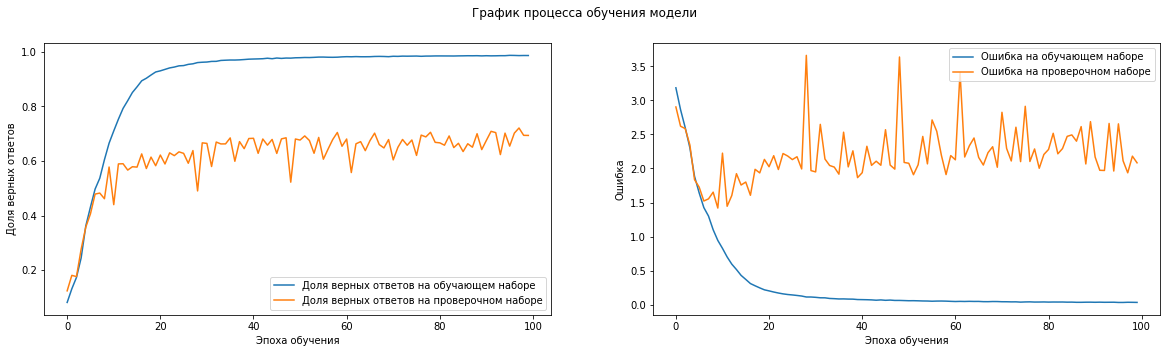

542/542 [==============================] - 20s 33ms/step


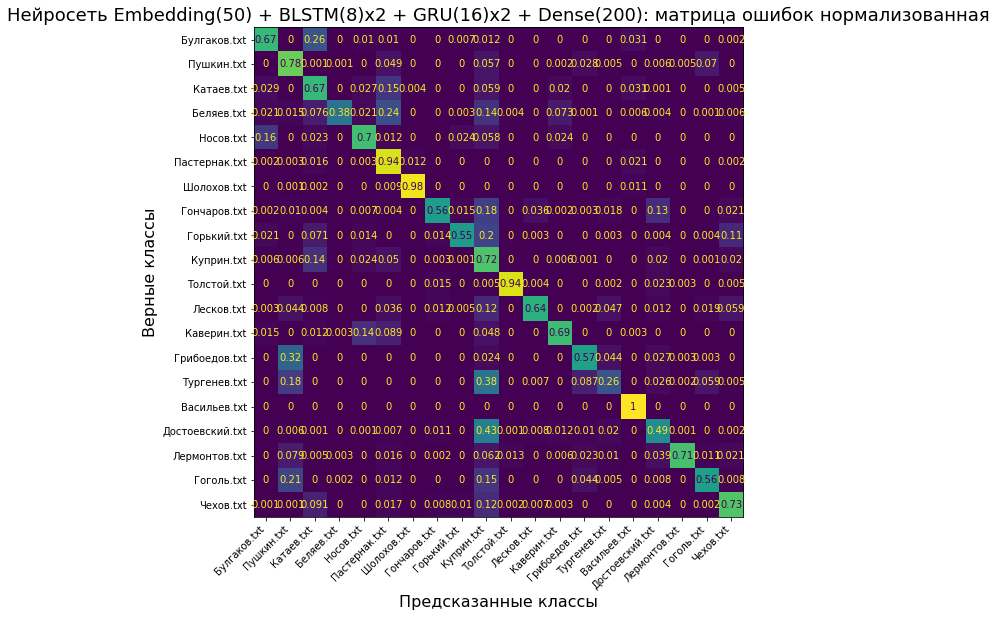

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Булгаков.txt          67% сеть отнесла к классу Булгаков.txt         - ВЕРНО :-)
Класс: Пушкин.txt            78% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Катаев.txt            67% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Беляев.txt            38% сеть отнесла к классу Беляев.txt           - ВЕРНО :-)
Класс: Носов.txt             70% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: Пастернак.txt         94% сеть отнесла к классу Пастернак.txt        - ВЕРНО :-)
Класс: Шолохов.txt           98% сеть отнесла к классу Шолохов.txt          - ВЕРНО :-)
Класс: Гончаров.txt          56% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Горький.txt           55% сеть отнесла к классу Горький.txt          - ВЕРНО :-)
Класс: Куприн.txt            72% сеть отнесл

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(10000, 50, input_length = 500))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())
# Два двунаправленных рекуррентных слоя LSTM
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
# Два рекуррентных слоя GRU
model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
# Дополнительный полносвязный слой
model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(20, activation='softmax'))

compile_train_eval_model(model_LSTM_6,
                         train_x, train_y,
                         test_x, test_y,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels = class_list,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

Conv1D

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 10)           100000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 10)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_2 (Batc  (None, 500, 10)          40        
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 500, 20)           1020      
                                                                 
 conv1d_3 (Conv1D)           (None, 496, 20)           2020      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 20)         

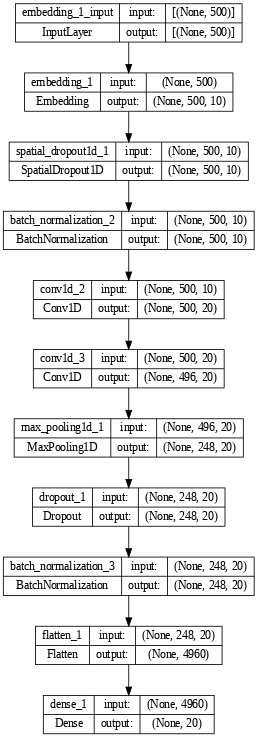

Epoch 1/100
346/346 [==============================] - 48s 99ms/step - loss: 2.1908 - accuracy: 0.3561 - val_loss: 2.9542 - val_accuracy: 0.2208
Epoch 2/100
346/346 [==============================] - 11s 31ms/step - loss: 0.4705 - accuracy: 0.8404 - val_loss: 1.2559 - val_accuracy: 0.6417
Epoch 3/100
346/346 [==============================] - 9s 26ms/step - loss: 0.2257 - accuracy: 0.9234 - val_loss: 1.1646 - val_accuracy: 0.7247
Epoch 4/100
346/346 [==============================] - 6s 17ms/step - loss: 0.1512 - accuracy: 0.9485 - val_loss: 1.3228 - val_accuracy: 0.7105
Epoch 5/100
346/346 [==============================] - 7s 19ms/step - loss: 0.1205 - accuracy: 0.9586 - val_loss: 1.1953 - val_accuracy: 0.7547
Epoch 6/100
346/346 [==============================] - 4s 13ms/step - loss: 0.1036 - accuracy: 0.9642 - val_loss: 1.6447 - val_accuracy: 0.6966
Epoch 7/100
346/346 [==============================] - 6s 16ms/step - loss: 0.0898 - accuracy: 0.9694 - val_loss: 1.5109 - val_accurac

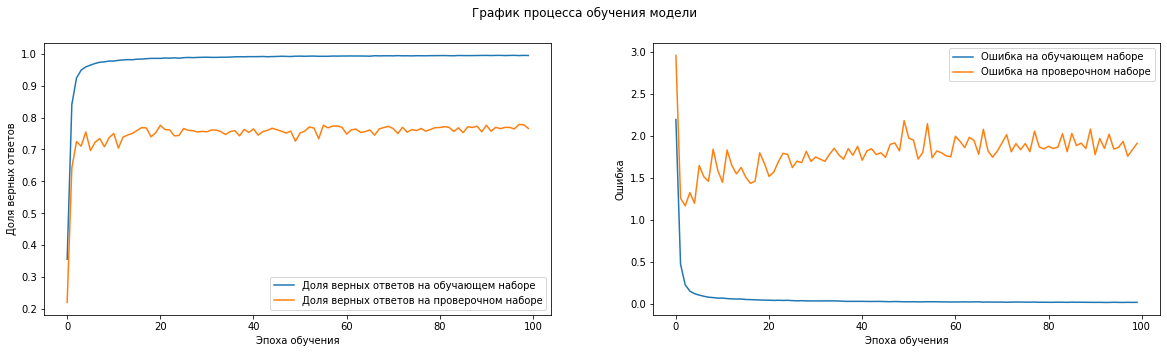

542/542 [==============================] - 2s 3ms/step


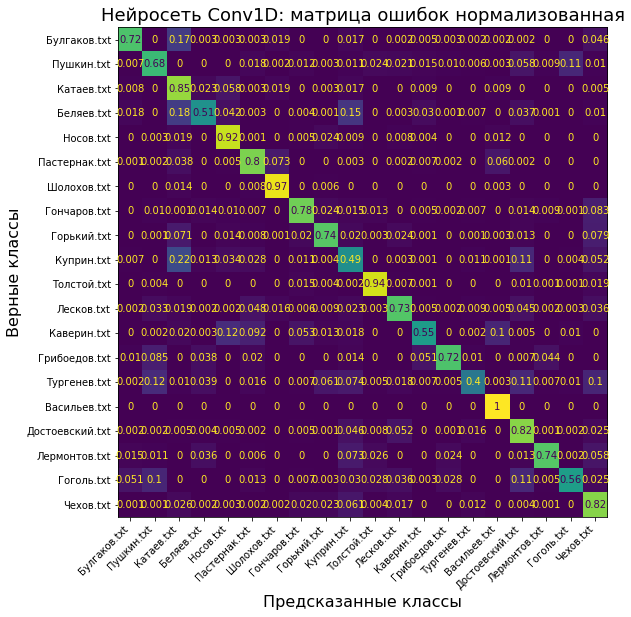

----------------------------------------------------------------------------------------------------
Нейросеть: Conv1D
Класс: Булгаков.txt          72% сеть отнесла к классу Булгаков.txt         - ВЕРНО :-)
Класс: Пушкин.txt            68% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Катаев.txt            85% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Беляев.txt            51% сеть отнесла к классу Беляев.txt           - ВЕРНО :-)
Класс: Носов.txt             92% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: Пастернак.txt         80% сеть отнесла к классу Пастернак.txt        - ВЕРНО :-)
Класс: Шолохов.txt           97% сеть отнесла к классу Шолохов.txt          - ВЕРНО :-)
Класс: Гончаров.txt          78% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Горький.txt           74% сеть отнесла к классу Горький.txt          - ВЕРНО :-)
Класс: Куприн.txt            49% сеть отнесла к классу Куприн.txt           - ВЕРНО :-)
К

In [ ]:
model_Conv_1 = Sequential()
model_Conv_1.add(Embedding(10000, 10, input_length= 500))
model_Conv_1.add(SpatialDropout1D(0.2))
model_Conv_1.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_1.add(Conv1D(20, 5, activation='relu', padding='same'))
model_Conv_1.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(MaxPooling1D(2))
model_Conv_1.add(Dropout(0.2))
model_Conv_1.add(BatchNormalization())
model_Conv_1.add(Flatten())
model_Conv_1.add(Dense(20, activation='softmax'))

compile_train_eval_model(model_Conv_1,
                         train_x, train_y,
                         test_x, test_y,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels= class_list,
                         title='Conv1D')

LSTM + Conv1D №3

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 10)           100000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 500, 10)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_5 (Conv1D)           (None, 496, 20)           1020      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 248, 20)          0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 248, 20)           0         
                                                                 
 batch_normalization_10 (Bat  (None, 248, 20)         

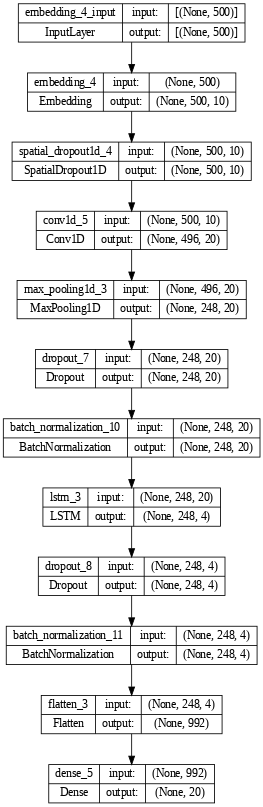

Epoch 1/100
346/346 [==============================] - 23s 57ms/step - loss: 2.1700 - accuracy: 0.3251 - val_loss: 3.7150 - val_accuracy: 0.0690
Epoch 2/100
346/346 [==============================] - 9s 25ms/step - loss: 0.7251 - accuracy: 0.7470 - val_loss: 1.2613 - val_accuracy: 0.6395
Epoch 3/100
346/346 [==============================] - 7s 20ms/step - loss: 0.4143 - accuracy: 0.8571 - val_loss: 1.3199 - val_accuracy: 0.6729
Epoch 4/100
346/346 [==============================] - 7s 19ms/step - loss: 0.3111 - accuracy: 0.8914 - val_loss: 1.3309 - val_accuracy: 0.6985
Epoch 5/100
346/346 [==============================] - 6s 16ms/step - loss: 0.2557 - accuracy: 0.9113 - val_loss: 1.5246 - val_accuracy: 0.6769
Epoch 6/100
346/346 [==============================] - 6s 17ms/step - loss: 0.2257 - accuracy: 0.9231 - val_loss: 1.9311 - val_accuracy: 0.6549
Epoch 7/100
346/346 [==============================] - 6s 16ms/step - loss: 0.2040 - accuracy: 0.9288 - val_loss: 1.6279 - val_accuracy

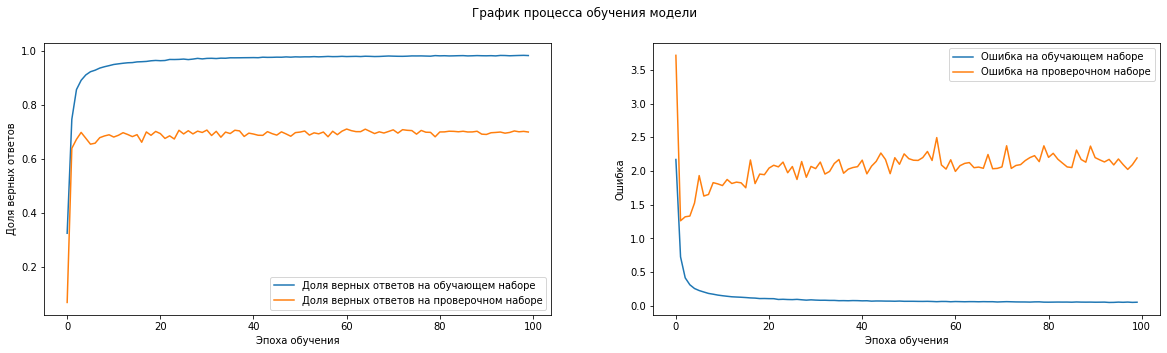

542/542 [==============================] - 3s 5ms/step


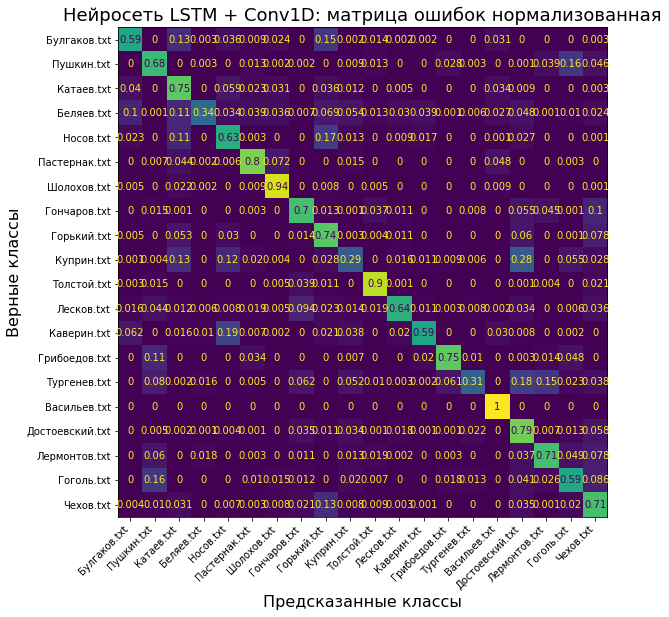

----------------------------------------------------------------------------------------------------
Нейросеть: LSTM + Conv1D
Класс: Булгаков.txt          60% сеть отнесла к классу Булгаков.txt         - ВЕРНО :-)
Класс: Пушкин.txt            68% сеть отнесла к классу Пушкин.txt           - ВЕРНО :-)
Класс: Катаев.txt            75% сеть отнесла к классу Катаев.txt           - ВЕРНО :-)
Класс: Беляев.txt            34% сеть отнесла к классу Беляев.txt           - ВЕРНО :-)
Класс: Носов.txt             63% сеть отнесла к классу Носов.txt            - ВЕРНО :-)
Класс: Пастернак.txt         80% сеть отнесла к классу Пастернак.txt        - ВЕРНО :-)
Класс: Шолохов.txt           94% сеть отнесла к классу Шолохов.txt          - ВЕРНО :-)
Класс: Гончаров.txt          70% сеть отнесла к классу Гончаров.txt         - ВЕРНО :-)
Класс: Горький.txt           74% сеть отнесла к классу Горький.txt          - ВЕРНО :-)
Класс: Куприн.txt            29% сеть отнесла к классу Куприн.txt           - ВЕРН

In [ ]:
model_LC_3 = Sequential()
model_LC_3.add(Embedding(10000, 10, input_length= 500))
model_LC_3.add(SpatialDropout1D(0.2))
# Сверточный слой
model_LC_3.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_LC_3.add(MaxPooling1D(2))
# Слой регуляризации Dropout
model_LC_3.add(Dropout(0.2))
# Слой пакетной нормализации
model_LC_3.add(BatchNormalization())
# Рекуррентный слой LSTM
model_LC_3.add(LSTM(4, return_sequences=1))
model_LC_3.add(Dropout(0.2))
model_LC_3.add(BatchNormalization())
# Слой выравнивания/сглаживания ("сплющивание" данных в вектор)
model_LC_3.add(Flatten())
model_LC_3.add(Dense(20, activation='softmax'))

compile_train_eval_model(model_LC_3,
                         train_x, train_y,
                         test_x, test_y,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=200,
                         class_labels=class_list,
                         title='LSTM + Conv1D')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
#os.mkdir('/content/drive/MyDrive/Colab Notebooks/model_Conv1D_hw_6')
path_to_model = '/content/drive/MyDrive/Colab Notebooks/model_Conv1D_hw_6'
#model_Conv_1.save(path_to_model)
model = load_model(path_to_model)

In [ ]:
my_text = '/content/drive/MyDrive/дз1Озивская.txt'
my_text_x = []
with open(f'{my_text}', 'r',  encoding="windows-1251") as f:
            text = f.read()
            text = text.replace('\n', ' ')
            my_text_x.append(text)
            print(my_text_x)

['Я решила написать о представителе раннего гуманизма, человеке эпохи Возрождения Джованни Пико делла Мирандола. Рассказывая о Джованни летописцы восторженно говорят: “история жизни интеллекта” или “судьба интеллекта” и, действительно, если верить историкам, Джованни с детства был одарен невероятно. Уже в возрасте 10-ти лет он прославился в качестве великолепного оратора и поэта, а 14 поступил в самый старый европейский университет в Болонье. Поступил на отделение филологии и очень активно увлекся языками, по некоторым данным к двадцати годам Джованни знал больше 20 языков или, по крайней мере, мог читать тексты более чем на 20 языках, среди которых были халдейский, арабский, арамейский и древнееврейский. Он наизусть читал «Божественную комедию» с последнего стиха до первого.  Про многих людей, о которых можно сказать – великий, сочиняют легенды и мифы, эта традиция не обошла и субъект моего рассмотрения. В общем, эта картина представляется мне так: мрачная просторная комната, озаряема

In [ ]:
# переводим в токен а затем ...
tokenizer.fit_on_texts(my_text_x)

In [ ]:
my_test_seq = tokenizer.texts_to_sequences(my_text_x)

my_test_x, _ = vec(train_seq)

In [ ]:
print(my_test_x.shape)

(3, 500)


In [ ]:
# Выполним распознавание писателя
y_pred = model_Conv_1.predict(my_test_x)

1/1 [==============================] - 1s 590ms/step


In [ ]:
print(y_pred)

[[6.82305412e-08 2.36451347e-09 6.18160376e-03 1.16816270e-11
  6.12296935e-06 4.89118156e-06 6.78490082e-08 2.33041646e-07
  1.64294941e-03 9.87008631e-01 1.11443166e-09 4.95192269e-03
  1.88404535e-11 7.27633692e-14 9.32518596e-09 1.56393071e-05
  3.36403136e-05 1.24099770e-08 2.40981190e-05 1.30147528e-04]
 [5.41236261e-07 5.43866241e-09 1.37323765e-02 1.59986201e-13
  3.43821582e-10 4.80169547e-07 1.40621443e-04 9.22950258e-12
  6.90488087e-05 1.26038853e-03 2.47043185e-12 9.84720886e-01
  2.01617875e-10 3.18996999e-13 1.21214754e-07 6.83081744e-05
  1.99462556e-06 3.38770922e-13 1.38340062e-10 5.16372711e-06]
 [1.54902864e-05 1.31157151e-07 2.08791956e-01 5.37112022e-12
  6.89124424e-10 3.24882531e-05 1.72815940e-04 9.25613839e-12
  8.65896174e-04 1.32465735e-03 1.08996222e-10 6.40267909e-01
  7.78053837e-14 5.33523800e-13 2.72181514e-05 1.08043901e-06
  3.91782550e-07 1.14967974e-11 3.09041241e-07 1.48499712e-01]]


In [ ]:
r = np.argmax(y_pred, axis=1)                     # Найдем индексы писателей
unique, counts = np.unique(r, return_counts=True) # Найдем полученые индексы и их количество
counts = counts/y_pred.shape[0]*100               # Считаем долю каждного полученного индекса
print(unique, counts)

[ 9 11] [33.33333333 66.66666667]


In [ ]:
# Выведем результат предсказания

for i in range(len(unique)):
  print('{:10s} - {:<.2f}%'.format(class_list[unique[i]],counts[i]))

Куприн.txt - 33.33%
Лесков.txt - 66.67%


In [ ]:
my_text = '/content/drive/MyDrive/LEVIN_IVAN.txt'
my_text_x = []
with open(f'{my_text}', 'r',  encoding="windows-1251") as f:
            text = f.read()
            text = text.replace('\n', ' ')
            my_text_x.append(text)
            print(my_text_x)

['Если ты что-то весишь, ты будешь неизбежно притягивать другое массивное тело. Вопрос лишь в том, насколько ты тяжелый, и насколько ты далёк от цели. Это так называемый закон Всемирного тяготения, который знает каждый школьник: тааак, тут значит массу в числитель, ага, квадрат расстояния в знаменатель, вот-вот, а ещё же препод про радиус-вектор что-то говорил, домножать на него что ли, а как тогда с размерностью быть, таак падажжи... И экспериментально это всё подтверждается: отпустишь из рук предмет, он упадёт: как яблоко, которое висело-висело, а потом Ньютону (или всё-таки Ньютону?) по лбу стукнуло. Ну и чем дальше ты от другого тела, тем тяжелее тебе надо быть, чтоб какое-то заметное воздействие на него оказывать (как Плутон, которого так сперва теоретически предсказали, а потом фактически открыли). Вот, а теперь вопрос: если тело уж оочень сильно удалено от другого, то откуда ж оно узнает, что нужно кого-то к себе притягивать. У него есть только масса, иными словами только возмож

In [ ]:
tokenizer.fit_on_texts(my_text_x)
my_test_seq = tokenizer.texts_to_sequences(my_text_x)
my_test_x, _ = vec(train_seq)
y_pred = model.predict(my_test_x)
r = np.argmax(y_pred, axis=1)                     # Найдем индексы писателей
unique, counts = np.unique(r, return_counts=True) # Найдем полученые индексы и их количество
counts = counts/y_pred.shape[0]*100               # Считаем долю каждного полученного индекса
# Выведем результат предсказания

for i in range(len(unique)):
  print('{:10s} - {:<.2f}%'.format(class_list[unique[i]],counts[i]))

2162/2162 [==============================] - 26s 12ms/step
Булгаков.txt - 3.46%
Чехов.txt  - 5.79%
Катаев.txt - 4.71%
Горький.txt - 3.77%
Каверин.txt - 4.36%
Толстой.txt - 5.24%
Гоголь.txt - 5.85%
Лесков.txt - 5.59%
Шолохов.txt - 4.68%
Гончаров.txt - 4.14%
Беляев.txt - 5.87%
Носов.txt  - 3.98%
Лермонтов.txt - 3.45%
Достоевский.txt - 1.67%
Пушкин.txt - 3.62%
Куприн.txt - 5.16%
Грибоедов.txt - 9.50%
Пастернак.txt - 3.53%
Тургенев.txt - 3.45%
Васильев.txt - 12.19%
